In [50]:
import os
import spacy
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from sklearn.metrics import silhouette_score

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [3]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df.head()

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str
7475327,2010-01-01 00:01:00,1556,2972,-77.0,"""Swipe Transaction""",59935,"""Beulah""","""ND""",58523.0,"""5499""",null,"""Miscellaneous Food Stores""","""No""",30,67,1989,7,"""Female""","""594 Mountain View Street""",46.8,-100.76,23679.0,48277.0,110153.0,740,4,"""Mastercard""","""Debit (Prepaid)""",5497590243197280,"""07/2022""",306,"""YES""",2,55.0,"""05/2008""",2008,"""No"""
7475328,2010-01-01 00:02:00,561,4575,14.57,"""Swipe Transaction""",67570,"""Bettendorf""","""IA""",52722.0,"""5311""",null,"""Department Stores""","""No""",48,67,1971,6,"""Male""","""604 Pine Street""",40.8,-91.12,18076.0,36853.0,112139.0,834,5,"""Mastercard""","""Credit""",5175842699412235,"""12/2024""",438,"""YES""",1,9100.0,"""09/2005""",2015,"""No"""
7475329,2010-01-01 00:02:00,1129,102,80.0,"""Swipe Transaction""",27092,"""Vista""","""CA""",92084.0,"""4829""",null,"""Money Transfer""","""No""",49,65,1970,4,"""Male""","""2379 Forest Lane""",33.18,-117.29,16894.0,34449.0,36540.0,686,3,"""Mastercard""","""Debit""",5874992802287595,"""05/2020""",256,"""YES""",1,14802.0,"""01/2006""",2008,"""No"""
7475332,2010-01-01 00:06:00,848,3915,46.41,"""Swipe Transaction""",13051,"""Harwood""","""MD""",20776.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",51,69,1968,5,"""Male""","""166 River Drive""",38.86,-76.6,33529.0,68362.0,96182.0,711,2,"""Visa""","""Debit""",4354185735186651,"""01/2020""",120,"""YES""",1,19113.0,"""07/2009""",2014,"""No"""
7475333,2010-01-01 00:07:00,1807,165,4.81,"""Swipe Transaction""",20519,"""Bronx""","""NY""",10464.0,"""5942""",null,"""Book Stores""","""No""",47,65,1972,12,"""Female""","""14780 Plum Lane""",40.84,-73.87,25537.0,52065.0,98613.0,828,5,"""Mastercard""","""Debit (Prepaid)""",5207231566469664,"""03/2014""",198,"""YES""",1,89.0,"""01/2008""",2015,"""No"""


In [4]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
)
df.sample(5)

id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,target,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,online_sales,city,country
i64,datetime[ns],i64,i64,f64,str,i64,str,str,f64,str,str,str,str,i64,i64,i64,i64,str,str,f64,f64,f64,f64,f64,i64,i64,str,str,i64,str,i64,str,i64,f64,str,i64,str,str,str,str
8617971,2010-10-09 18:23:00,1383,4949,54.2,"""Swipe Transaction""",32076,"""Slanesville""","""WV""",25444.0,"""5813""",null,"""Drinking Places (Alcoholic Bev…","""No""",68,64,1951,4,"""Female""","""315 Norfolk Lane""",42.39,-71.1,31849.0,59938.0,36978.0,670,1,"""Mastercard""","""Debit""",5027291418907395,"""02/2022""",118,"""YES""",1,17432.0,"""10/2001""",2014,"""No""","""No""","""Slanesville""","""United States"""
15905282,2015-04-04 18:46:00,1330,4579,48.41,"""Online Transaction""",15143,"""ONLINE""",null,null,"""4784""",null,"""Tolls and Bridge Fees""","""No""",65,61,1954,12,"""Female""","""35187 West Lane""",34.4,-119.72,33097.0,35404.0,30887.0,575,3,"""Mastercard""","""Debit""",5728056480439167,"""06/2024""",992,"""YES""",2,14448.0,"""09/2005""",2011,"""No""","""Yes""","""Online""","""Online"""
22199217,2018-12-05 07:02:00,1357,5105,1.38,"""Chip Transaction""",83271,"""Tacoma""","""WA""",98445.0,"""4214""",null,"""Motor Freight Carriers and Tru…","""No""",75,65,1944,12,"""Female""","""402 Birch Boulevard""",47.2,-122.4,16941.0,11410.0,0.0,812,7,"""Amex""","""Credit""",305833889455873,"""07/2024""",198,"""YES""",2,7500.0,"""10/2008""",2008,"""No""","""No""","""Tacoma""","""United States"""
8958378,2010-12-30 04:15:00,20,5011,2.62,"""Swipe Transaction""",83161,"""Venus""","""TX""",76084.0,"""5812""",null,"""Eating Places and Restaurants""","""No""",86,67,1933,12,"""Female""","""3631 Plum Boulevard""",32.42,-97.1,19477.0,23371.0,0.0,757,8,"""Mastercard""","""Credit""",5881351669070746,"""03/2021""",834,"""YES""",2,9000.0,"""10/2004""",2011,"""No""","""No""","""Venus""","""United States"""
12627292,2013-04-18 07:17:00,954,5586,120.0,"""Swipe Transaction""",27092,"""Riverside""","""CA""",92508.0,"""4829""",null,"""Money Transfer""","""No""",51,65,1968,6,"""Male""","""691 Ocean View Street""",33.93,-117.49,18619.0,37963.0,102716.0,772,4,"""Visa""","""Debit""",4089300388076101,"""10/2024""",359,"""YES""",1,24104.0,"""11/2009""",2009,"""No""","""No""","""Riverside""","""United States"""


In [5]:
def floor_to_15min(dt_value: datetime) -> datetime|None:
    if dt_value is None:
        return None

    seconds_since_midnight = (dt_value - dt_value.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()
    interval_seconds = 15 * 60
    floored_seconds = (seconds_since_midnight // interval_seconds) * interval_seconds
    return dt_value.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=floored_seconds)

In [6]:
df = df.with_columns(
    pl.col("date").map_elements(floor_to_15min, return_dtype=pl.Datetime).alias("date_window")
)

In [7]:
def generate_columns_statistics(column_name: str) -> list:
    return [
        pl.col(column_name).mean().alias(f'mean_{column_name}'),
        pl.col(column_name).std().alias(f'std_{column_name}'),
        pl.col(column_name).skew().alias(f'skew_{column_name}'),
        pl.col(column_name).kurtosis().alias(f'kurtosis_{column_name}')
    ]

In [8]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [9]:
aggregate = [pl.col('amount').count().alias('transactions'), pl.col('target').sum().alias('frauds')]
for column in ['amount', 'current_age', 'per_capita_income', 'total_debt', 'credit_score', 'num_credit_cards', 'credit_limit']:
  aggregate.extend(generate_columns_statistics(column))

In [10]:
def list_structs_to_dict(list_of_structs, column_name):
  if list_of_structs is None:
      return None

  items = {}
  for item in list_of_structs:
    key = item[column_name]
    value = round(item['proportion'], 2)
    items[key] = value

  return items

def convert_categorical_to_percent(df: pl.DataFrame, column_name: str, group_by_column) -> pl.DataFrame:
  list_structs_to_dict_column = lambda items: list_structs_to_dict(items, column_name)

  df_group = df.group_by(group_by_column).agg(pl.col(column_name).value_counts(normalize=True)).sort(group_by_column)

  df_fields = df_group.with_columns(
    pl.col(column_name).map_elements(
        list_structs_to_dict_column,
        return_dtype=pl.Object
  ).alias(column_name))

  fields = df_fields[column_name].to_list()
  data = pd.DataFrame(fields).fillna(0.0)
  data.columns = [f'{column_name}_{col.lower().replace(" ", "_")}' for col in data.columns]
  # data[group_by_column] = df_fields[group_by_column].to_list()
  data = pl.from_pandas(data)
  data = data.with_columns(df_fields[group_by_column].alias(group_by_column))
  return data

In [11]:
df_model = df.group_by('date_window').agg(
    *aggregate
).sort('date_window')
df_model.head()

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726


In [12]:
for column in ['use_chip', 'gender', 'card_brand', 'card_type', 'has_chip', 'online_sales']:
  df_field = convert_categorical_to_percent(df, column, 'date_window')
  df_model = df_model.join(df_field, on='date_window', how='left')
df_model.head(10)

date_window,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,mean_per_capita_income,std_per_capita_income,skew_per_capita_income,kurtosis_per_capita_income,mean_total_debt,std_total_debt,skew_total_debt,kurtosis_total_debt,mean_credit_score,std_credit_score,skew_credit_score,kurtosis_credit_score,mean_num_credit_cards,std_num_credit_cards,skew_num_credit_cards,kurtosis_num_credit_cards,mean_credit_limit,std_credit_limit,skew_credit_limit,kurtosis_credit_limit,use_chip_swipe_transaction,use_chip_online_transaction,use_chip_chip_transaction,gender_female,gender_male,card_brand_mastercard,card_brand_visa,card_brand_amex,card_brand_discover,card_type_debit,card_type_debit_(prepaid),card_type_credit,has_chip_yes,has_chip_no,online_sales_no,online_sales_yes
datetime[μs],u32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-01-01 00:00:00,6,0,15.875,52.737742,-0.760483,-0.139116,46.833333,8.841191,-1.241314,0.444023,21897.166667,7198.264219,0.522412,-0.861983,93656.666667,28711.635012,-1.594374,0.842529,763.5,61.29845,0.001812,-1.536333,4.0,1.264911,-0.649519,-1.125,7200.833333,8439.396078,0.381076,-1.520432,0.83,0.17,0.0,0.33,0.67,0.83,0.17,0.0,0.0,0.33,0.5,0.17,1.0,0.0,0.83,0.17
2010-01-01 00:15:00,4,0,22.2625,22.245049,0.012927,-1.980469,49.5,16.663333,-0.134765,-1.560644,24534.0,1301.539345,0.354425,-1.461239,60605.5,59834.776479,-0.01997,-1.967191,724.5,24.310492,-0.830693,-0.974824,4.25,0.957427,-0.493382,-1.371901,12608.5,13718.592311,0.010111,-1.972188,1.0,0.0,0.0,0.25,0.75,0.25,0.75,0.0,0.0,0.75,0.25,0.0,0.75,0.25,1.0,0.0
2010-01-01 00:30:00,10,0,34.644,45.188942,-0.779579,0.46044,48.6,4.993329,-0.461034,0.602038,21695.6,6709.572916,0.674351,-0.812142,56477.3,48226.48252,0.235514,-1.124026,700.3,63.4421,-1.464207,2.09804,3.8,1.316561,-0.541972,0.607495,19807.9,6338.6096,0.114952,-1.629159,0.8,0.2,0.0,0.5,0.5,0.8,0.2,0.0,0.0,0.6,0.0,0.4,1.0,0.0,0.8,0.2
2010-01-01 00:45:00,6,0,15.388333,14.262798,0.910151,-0.471315,70.5,18.251027,0.262932,-1.015413,19808.166667,3592.733245,0.927645,-0.439468,40391.666667,51012.043302,0.59751,-1.399093,772.166667,41.421814,-0.0949,-1.491414,5.333333,1.632993,-0.279508,-1.365,17533.666667,11039.367893,-0.713338,-1.100947,0.83,0.17,0.0,0.5,0.5,0.5,0.33,0.17,0.0,0.67,0.17,0.17,1.0,0.0,0.83,0.17
2010-01-01 01:00:00,6,0,101.018333,97.728056,0.816882,-0.48396,54.5,9.648834,0.573632,-1.012784,26342.666667,15248.228011,1.251008,0.412107,67331.166667,35267.904737,0.400987,-1.525858,730.333333,83.946809,0.055991,-1.513659,3.833333,1.47196,-0.519038,-1.56071,23233.333333,20657.262681,1.339601,0.337726,0.5,0.5,0.0,0.67,0.33,0.83,0.17,0.0,0.0,0.67,0.0,0.33,1.0,0.0,0.5,0.5
2010-01-01 01:15:00,5,0,4.61,53.67871,-0.468739,-0.482601,43.6,7.402702,-0.754216,-0.771215,23935.4,3065.888664,0.013807,-0.528075,81437.8,28100.092281,1.039823,-0.491354,754.0,56.178288,1.098869,-0.206714,3.0,1.0,0.0,-1.75,14693.8,4012.619369,-0.062165,-1.724288,1.0,0.0,0.0,0.8,0.2,0.6,0.4,0.0,0.0,0.6,0.0,0.4,0.8,0.2,1.0,0.0
2010-01-01 01:30:00,4,0,17.535,17.586155,0.425266,-1.453984,67.0,20.314199,0.318187,-1.563732,25778.5,6119.646749,-0.905558,-0.842706,30717.5,34917.933869,0.121262,-1.83475,747.0,52.36411,0.19568,-1.262078,6.25,0.5,1.154701,-0.666667,24618.5,11453.384085,0.474271,-1.360883,1.0,0.0,0.0,1.0,0.0,0.75,0.0,0.25,0.0,0.75,0.0,0.25,1.0,0.0,1.0,0.0
2010-01-01 01:45:00,7,0,51.992857,34.98547,1.019653,-0.01202,56.428571,11.544943,-0.075079,-1.292404,25930.0,12385.902524,1.407045,0.814717,51734.285714,42299.149521,0.614604,-0.406747,726.285714,37.187427,-0.51775,-0.245965,4.285714,1.704336,-0.040073,-1.64781,21924.571429,25060.956213,1.683264,1.455575,0.57,0.43,0.0,0.57,0.43,0.57,0.29,0.14,0.0,0.71,0.14,0.14,1.0,0.0,0.57,0.43
2010-01-01 02:00:00,9,0,45.843333,68.940091,1.30041,0.377724,50.0,21.75431,1.6103

In [13]:
corr = df_model.to_pandas().drop(columns=['date_window']).corr()
corr

,transactions,frauds,mean_amount,std_amount,skew_amount,kurtosis_amount,mean_current_age,std_current_age,skew_current_age,kurtosis_current_age,...,card_brand_visa,card_brand_amex,card_brand_discover,card_type_debit,card_type_debit_(prepaid),card_type_credit,has_chip_yes,has_chip_no,online_sales_no,online_sales_yes
transactions,1.000000,0.144195,-0.207486,-0.042427,0.209899,0.479446,0.071177,0.167515,0.229943,0.309453,...,-0.012239,-0.011232,-0.021169,0.042953,-0.008966,-0.039239,-0.036913,0.036811,0.181031,-0.181144
frauds,0.144195,1.000000,-0.013223,0.015787,0.054092,0.084733,0.015555,0.022956,0.019535,0.023903,...,-0.003043,-0.003920,-0.001955,0.002030,0.003339,-0.003955,-0.003786,0.003754,-0.016429,0.016404
mean_amount,-0.207486,-0.013223,1.000000,0.467603,0.322003,0.029714,-0.005831,-0.020709,-0.067792,-0.081837,...,0.018018,0.034694,0.023750,-0.074679,-0.087855,0.128033,0.000264,-0.000244,-0.108504,0.108532
std_amount,-0.042427,0.015787,0.467603,1.000000,0.236284,0.405003,-0.001105,-0.004093,-0.017168,-0.005457,...,0.013758,0.029551,0.028186,-0.057599,-0.067580,0.098166,0.001790,-0.001795,-0.021771,0.021786
skew_amount,0.209899,0.054092,0.322003,0.236284,1.000000,0.516563,0.022977,0.045157,0.048170,0.067565,...,-0.002330,-0.004926,-0.005260,0.003576,0.013604,-0.011099,-0.010863,0.010813,0.016478,-0.016494
kurtosis_amount,0.479446,0.084733,0.029714,0.405003,0.516563,1.000000,0.034486,0.087633,0.119764,0.166678,...,-0.005462,-0.003835,-0.004604,0.014807,-0.010523,-0.009134,-0.021958,0.021886,0.091556,-0.091600
mean_current_age,0.071177,0.015555,-0.005831,-0.001105,0.022977,0.034486,1.000000,0.392399,-0.136432,-0.165796,...,0.010231,-0.005448,0.019068,0.003862,-0.005563,-0.000828,-0.018420,0.018408,-0.021865,0.021857
std_current_age,0.167515,0.022956,-0.020709,-0.004093,0.045157,0.087633,0.392399,1.000000,0.191441,-0.058309,...,-0.030964,-0.018907,0.030764,0.017081,-0.002990,-0.016065,0.014277,-0.014293,0.027246,-0.027265
skew_current_age,0.229943,0.019535,-0.067792,-0.017168,0.048170,0.119764,-0.136432,0.191441,1.000000,0.620802,...,0.004251,0.005440,0.002942,-0.002315,0.004575,0.000224,-0.003432,0.003412,0.062616,-0.062637
kurtosis_current_age,0.309453,0.023903,-0.081837,-0.005457,0.067565,0.166678,-0.165796,-0.058309,0.620802,1.000000,...,0.019001,0.003874,-0.008919,0.020005,-0.023867,-0.007233,-0.009462,0.009441,0.062074,-0.062104


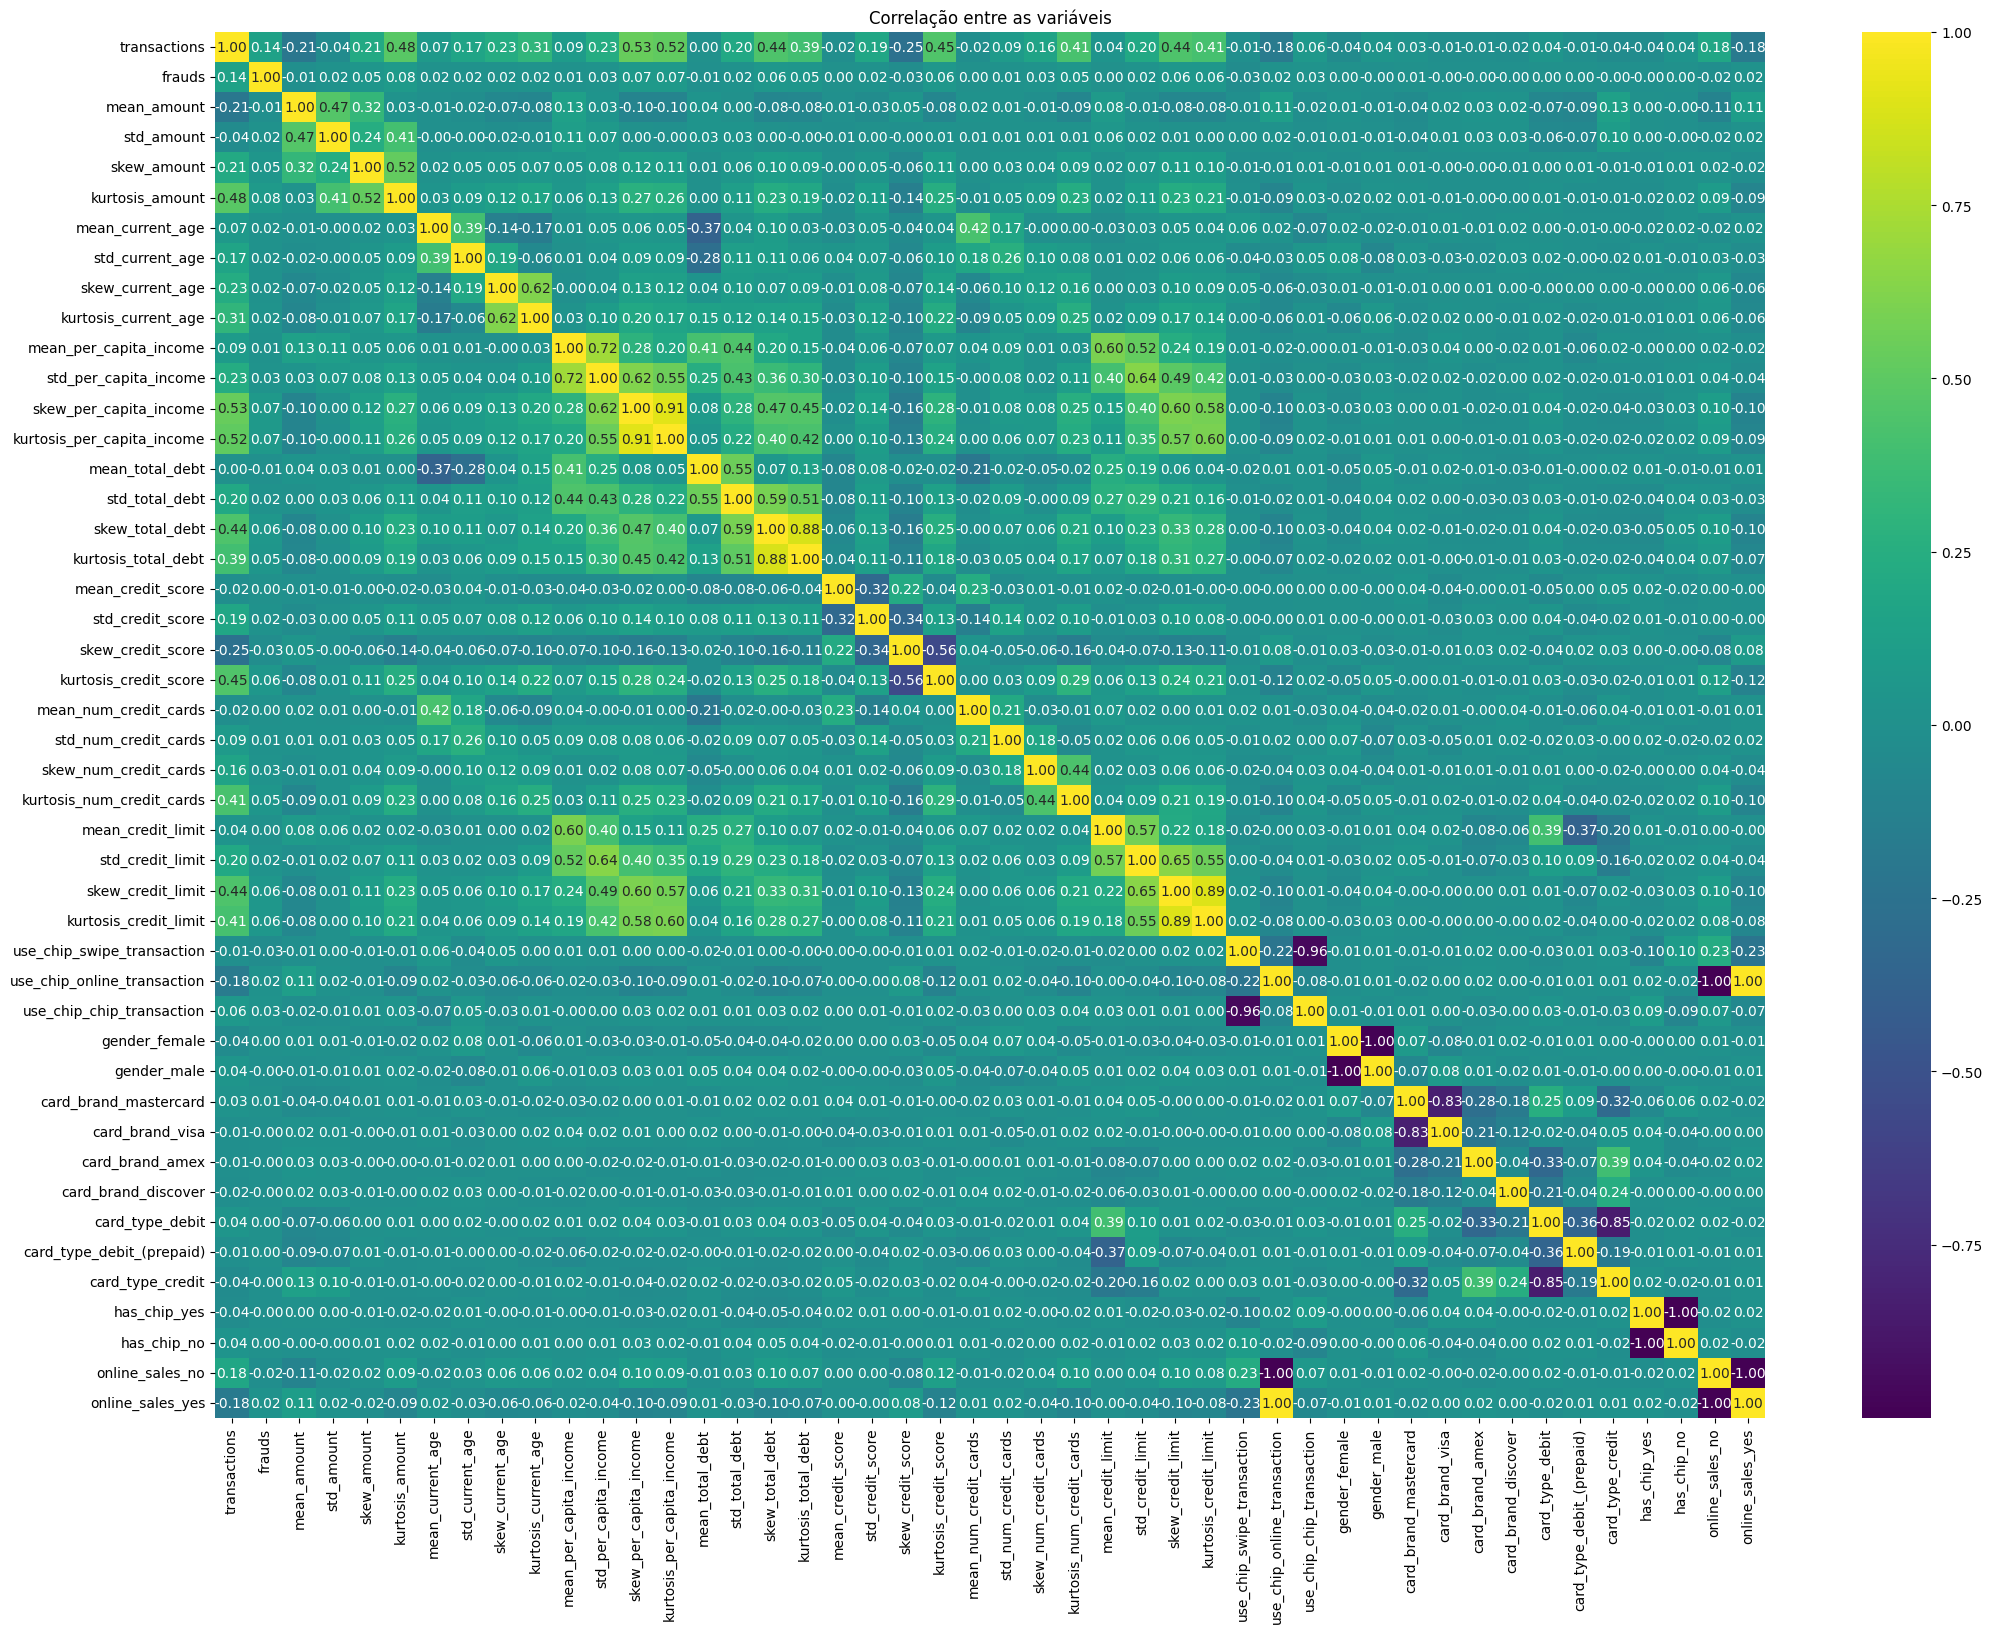

In [14]:
plt.figure(figsize=(25,18))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

In [15]:
df_proportion = df['description'].value_counts(normalize=True).sort('proportion', descending=True)
df_proportion.head()

description,proportion
str,f64
"""Grocery Stores, Supermarkets""",0.119668
"""Miscellaneous Food Stores""",0.10986
"""Service Stations""",0.107137
"""Eating Places and Restaurants""",0.075133
"""Drug Stores and Pharmacies""",0.058037


In [16]:
df_proportion.filter(pl.col('proportion') >= 0.01)['proportion'].sum()

0.8700672117203402

In [17]:
df_proportion.filter(pl.col('proportion') < 0.01)['proportion'].sum()

0.1299327882796597

In [18]:
df_proportion = df.group_by("description").agg([
    pl.len().alias("transaction_count"),
    pl.col("target").sum().alias("frauds"),
    pl.sum("amount").alias("total_amount"),
]).join(df_proportion, on='description', how='left')

In [19]:
df_proportion.head()

description,transaction_count,frauds,total_amount,proportion
str,u32,i32,f64,f64
"""Automotive Body Repair Shops""",757,5,291615.23,0.000085
"""Dentists and Orthodontists""",21744,10,3.4105e6,0.002439
"""Department Stores""",318511,2251,1.8131e7,0.035728
"""Leather Goods""",1895,16,1.3799e6,0.000213
"""Miscellaneous Machinery and Pa…",9538,81,745444.15,0.00107


In [20]:
df_proportion.filter(pl.col('proportion') >= 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.870067,7315


In [21]:
df_proportion.filter(pl.col('proportion') < 0.01)[['proportion', 'frauds']].sum()

proportion,frauds
f64,i32
0.129933,6017


In [22]:
nlp = spacy.load('en_core_web_sm')

In [23]:
categories = pl.DataFrame(df['description'].unique())
categories.columns = ['description']
categories.head()

description
str
"""Drinking Places (Alcoholic Bev…"
"""Beauty and Barber Shops"""
"""Non-Ferrous Metal Foundries"""
"""Brick, Stone, and Related Mate…"
"""Family Clothing Stores"""


In [24]:
categories = categories.with_columns(
    pl.col('description').map_elements(lambda x: nlp(x).vector).alias('vetor')
)
categories.head()

description,vetor
str,object
"""Drinking Places (Alcoholic Bev…",[-0.3232595 -0.1585616 -0.14356552 0.1636864 0.33006057 0.90379953 -0.25185362 0.46216547 0.05383809 -0.45920262 -0.37756443 -0.2661264 -0.6556583 -0.01876339 -0.5719149 -0.33347297 -0.38452205 0.18314278 0.23277886 -0.5629521 -0.6192694 -0.13208286 -0.2610523 0.3026147 0.35974827 0.1876455 0.3774267 -0.05001382 -0.27968892 1.1985714 0.19735269 0.32952186 -0.17279868 0.2132727 -0.29508176 -0.26131678 0.03278981 0.8562395 -0.38667884 0.02876575 -0.17258118 -0.20772374 -0.30282083 0.3008124 0.11923194 0.57658416 0.12617646 -0.5433652 0.25426397 -0.23795533 0.07532272 0.39302954 0.26574 -0.31907532 -0.39836693 -0.5180531 0.2479497 -0.18527097 0.02669749 -0.01676785 0.22171305 0.15781258 0.14079684 -0.38123894 -0.2553748 0.17286064 0.05193824 0.46762738 -0.22106187 -0.68396336 0.32263944 -0.49939463 0.4168457 -0.491026 0.6476089 0.3484805 -0.41490993 -0.12081224 -0.3023206 -0.39872217 0.14002366 0.13877957 -0.00945202 -0.5792715 -0.2897859 0.17457843 0.04913383 0.5804603 -0.34423387 0.3705226 0.13493693 0.505846 0.12969853 0.10834041 -0.16241683 0.28030372]
"""Beauty and Barber Shops""",[-0.05104037 0.09140077 -0.16612415 0.49133953 0.22837675 0.0163656 0.5928133 0.54385185 -0.18623686 0.21374957 -0.04928708 -0.2439992 -0.47697577 -0.85741127 -0.13200396 0.03402913 -0.3773529 0.31964266 0.25850433 -1.2092785 -0.76014435 0.18019193 0.21545239 0.0342108 0.29825893 -0.3426624 0.10044974 -0.51166946 -0.17896158 1.0651424 -0.8775124 -0.5991428 -0.16656345 -0.09633156 0.17452885 -0.35485336 0.7338625 0.5855378 -0.6092787 0.23999682 0.23030284 -0.24896154 -0.00351939 0.44868883 0.09226697 0.74478406 -0.58628994 -0.4803679 -0.49378538 -0.32705075 0.46918172 0.5612735 -0.60510695 -0.99463063 -0.2808987 -0.38037813 -0.00384883 -0.01176026 0.09444972 0.3575309 -0.33991823 0.19986004 0.10031673 -0.85247093 -0.31346184 0.34081855 0.8680575 1.0009787 0.10737295 -0.77747315 -0.02852147 -0.04928982 0.6905944 -0.5619011 0.6832337 0.05614002 -0.44220442 -0.42042738 -0.04762806 -0.13894047 0.8606995 -0.21824643 -0.02530937 0.45031187 0.27116287 0.33843148 -0.23780762 0.42883474 -0.7080742 0.16467483 -0.1028047 0.00623464 0.6889219 -0.22919813 0.6564614 0.32382256]
"""Non-Ferrous Metal Foundries""",[-0.21034452 -0.5406912 0.16874 0.8564846 -0.12151372 0.16520889 0.10874613 -0.13216099 -0.2520706 -0.26660278 0.3255114 0.01253854 -0.5080438 -0.2538306 -0.9037142 -0.16773263 0.22013673 -0.06361884 0.1836932 -0.8846961 -0.38215256 -0.28088492 -0.64499134 0.42451984 0.2989336 -0.30169043 -0.29330578 0.12663832 0.96033096 0.7847769 -0.02794864 -0.92527115 -0.0103533 0.0446087 -0.27812433 -0.69400644 0.7545992 0.66113955 -0.5004234 -0.19438985 -0.44508654 -0.20594318 0.22241111 0.410083 0.85690403 0.09478293 -0.12887545 0.18604288 -0.25608736 -0.10605649 -0.0415815 0.6761955 0.40602535 -0.7105868 -1.26778 1.0761577 0.44302493 0.04672894 -0.27052146 0.7947556 -0.20619504 0.4395286 -0.31690377 -0.92740345 -0.43895087 0.65556157 1.3314155 0.8783454 -0.30793604 -0.4218046 -0.09193233 0.00483437 0.8557477 -0.62877977 -0.24535628 0.0106422 -0.6600672 -0.5417873 -0.02994678 -0.39501828 -0.778088 0.43993983 0.071041 0.18096021 -0.2559232 0.10109121 0.54720795 0.08452675 -0.7021848 0.19667614 0.12302933 -0.1281822 0.7249089 0.50520194 -0.00994022 0.22882542]
"""Brick, Stone, and Related Mate…",[-0.1041646 -0.2870408 -0.20919728 0.46421042 0.34715933 0.717821 0.02853364 0.47407565 0.9033328 -0.38238996 0.507812 -0.4288403 -0.7220241 -0.33508426 -0.46748415 -0.37894505 -0.3944132 0.06500267 0.28620434 -0.87707156 -0.18469651 0.06432945 0.37629208 0.04979923 -0.2337363 0.34290108 0.16469768 -0.6301822 0.3672071 0.74950695 -0.20139019 -0.44193253 0.16190371 0.13550434 0.17481568 -0.3212165 0.40626174 0.49386898 -0.231665 -0.4412927 0.06938594 -0.44717678 0.05481119 0.3821962 -0.13081846 0.63120353 -0.39075023 -0.44330773 0.3647044 0.04895687 0.49493805 0.31252176 -0.33815208 -0.22617134 -0.03206018 0.16272

In [51]:
def calcular_qtd_clusters(data, max_clusters=10, plot=True):
    """
    Calcula a quantidade ideal de clusters usando o método do cotovelo e o índice de silhueta.

    Parâmetros:
    - data: array-like, dados de entrada (já reduzidos com PCA se necessário).
    - max_clusters: número máximo de clusters a testar.
    - plot: se True, plota os gráficos de avaliação.

    Retorna:
    - dicionário com inércia e silhouette para cada K.
    """
    inercia = []
    silhueta = []
    k_range = range(2, max_clusters + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        inercia.append(kmeans.inertia_)
        silhueta.append(silhouette_score(data, labels))

    if plot:
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        ax[0].plot(k_range, inercia, marker='o')
        ax[0].set_title('Método do Cotovelo')
        ax[0].set_xlabel('Número de Clusters')
        ax[0].set_ylabel('Inércia')

        ax[1].plot(k_range, silhueta, marker='o', color='green')
        ax[1].set_title('Índice de Silhueta')
        ax[1].set_xlabel('Número de Clusters')
        ax[1].set_ylabel('Silhouette Score')

        plt.tight_layout()
        plt.show()

    return {
        "inercia": dict(zip(k_range, inercia)),
        "silhouette": dict(zip(k_range, silhueta))
    }

In [88]:
pca = PCA(n_components=90)
components = pca.fit_transform(categories['vetor'].to_list())

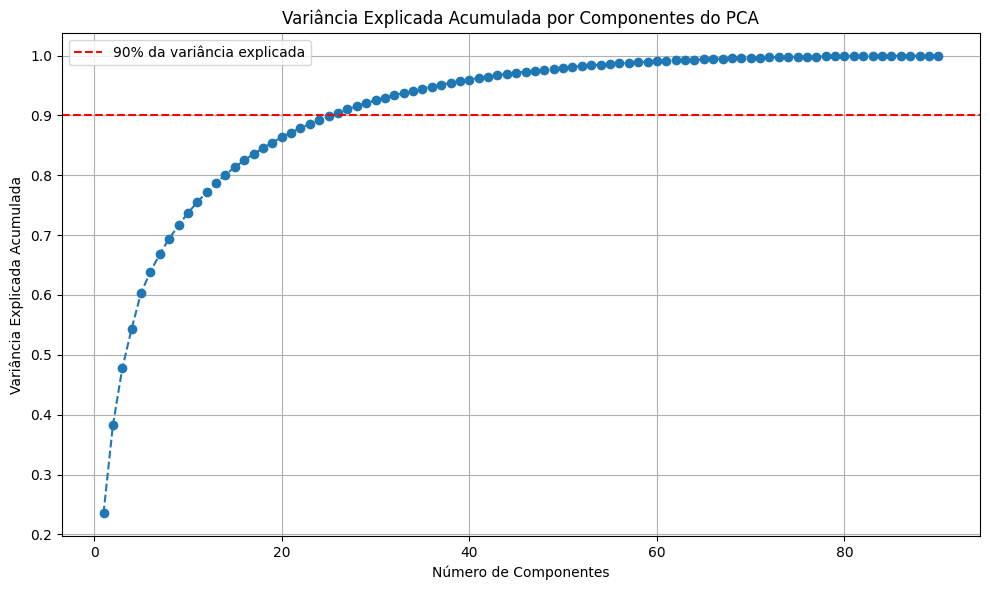

In [89]:
cumulative_variance  = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Variância Explicada Acumulada por Componentes do PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% da variância explicada')
plt.legend()
plt.tight_layout()
plt.show()

In [109]:
n_components = 22

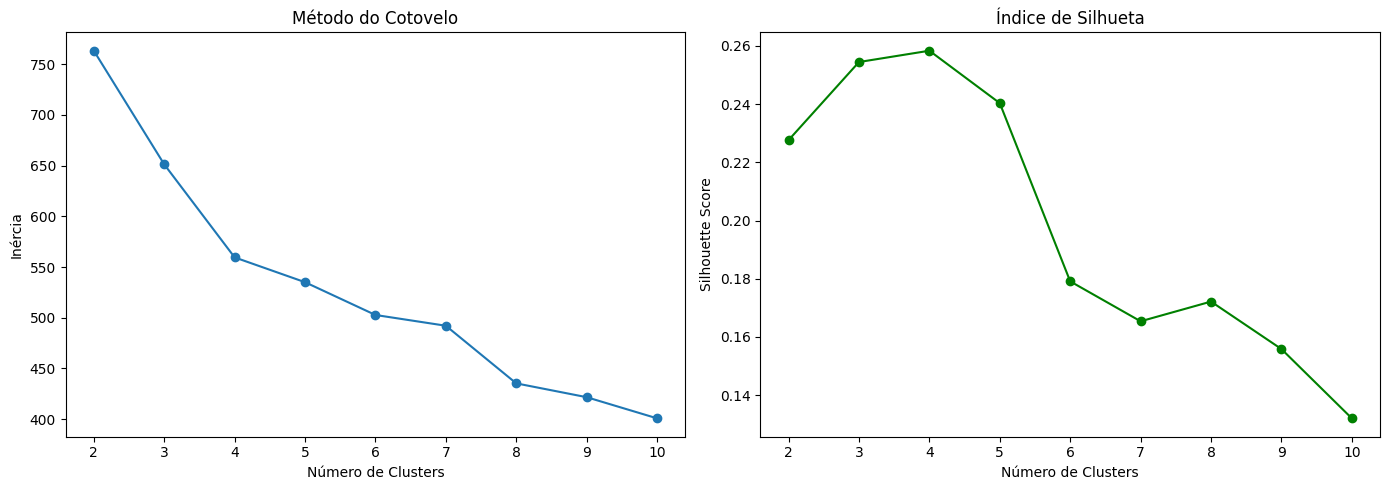

In [110]:
result = calcular_qtd_clusters(components[:, :n_components], plot=True)

In [111]:
n_clusters = list(result['silhouette'].keys())[np.argmax(list(result['silhouette'].values()))]
n_clusters

4

In [112]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(components[:, :n_components])
centroids = kmeans.cluster_centers_

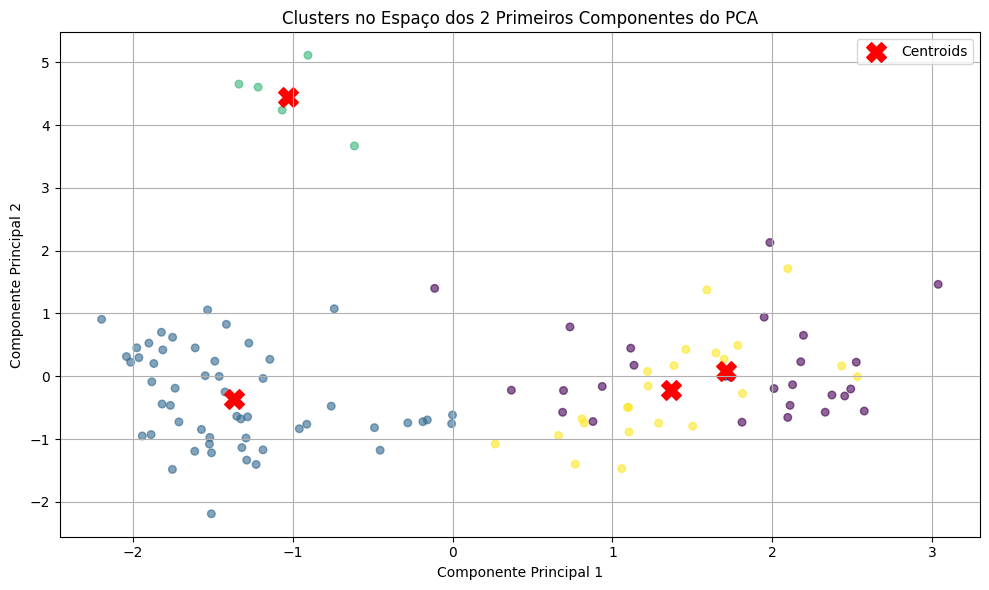

In [113]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(components[:, 0], components[:, 1], c=labels, cmap='viridis', alpha=0.6, s=30)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title('Clusters no Espaço dos 2 Primeiros Componentes do PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [114]:
df_proportion = df_proportion.with_columns(
    pl.lit(labels).alias('cluster')
)
df_proportion.head()

description,transaction_count,frauds,total_amount,proportion,cluster
str,u32,i32,f64,f64,i32
"""Automotive Body Repair Shops""",757,5,291615.23,0.000085,0
"""Dentists and Orthodontists""",21744,10,3.4105e6,0.002439,3
"""Department Stores""",318511,2251,1.8131e7,0.035728,1
"""Leather Goods""",1895,16,1.3799e6,0.000213,0
"""Miscellaneous Machinery and Pa…",9538,81,745444.15,0.00107,1


In [115]:
df_proportion.group_by('cluster').agg([
    pl.col('description').map_batches(lambda x: ', '.join(x)).alias('description'),
])

cluster,description
i32,list[str]
0,"[""Automotive Body Repair Shops, Leather Goods, Heating, Plumbing, Air Conditioning Contractors, Non-Ferrous Metal Foundries, Amusement Parks, Carnivals, Circuses, Book Stores, Miscellaneous Metalwork, Discount Stores, Steel Drums and Barrels, Digital Goods - Media, Books, Apps, Drug Stores and Pharmacies, Heat Treating Metal Services, Wholesale Clubs, Utilities - Electric, Gas, Water, Sanitary, Railroad Passenger Transport, Service Stations, Travel Agencies, Money Transfer, Towing Services, Railroad Freight, Telecommunication Services, Lighting, Fixtures, Electrical Supplies, Gift, Card, Novelty Stores, Cosmetic Stores, Electroplating, Plating, Polishing Services, Tolls and Bridge Fees, Welding Repair""]"
2,"[""Lodging - Hotels, Motels, Resorts, Automotive Parts and Accessories Stores, Package Stores, Beer, Wine, Liquor, Computer Network Services, Miscellaneous Home Furnishing Stores""]"
1,"[""Department Stores, Miscellaneous Machinery and Parts Manufacturing, Accounting, Auditing, and Bookkeeping Services, Medical Services, Recreational Sports, Clubs, Bolt, Nut, Screw, Rivet Manufacturing, Industrial Equipment and Supplies, Passenger Railways, Music Stores - Musical Instruments, Books, Periodicals, Newspapers, Hardware Stores, Household Appliance Stores, Eating Places and Restaurants, Family Clothing Stores, Cleaning and Maintenance Services, Brick, Stone, and Related Materials, Tax Preparation Services, Miscellaneous Fabricated Metal Products, Chiropractors, Ironwork, Podiatrists, Pottery and Ceramics, Doctors, Physicians, Computers, Computer Peripheral Equipment, Miscellaneous Metal Fabrication, Lawn and Garden Supply Stores, Coated and Laminated Products, Gardening Supplies, Hospitals, Laundry Services, Grocery Stores, Supermarkets, Lumber and Building Materials, Cruise Lines, Ship Chandlers, Precious Stones and Metals, Local and Suburban Commuter Transportation, Insurance Sales, Underwriting, Optometrists, Optical Goods and Eyeglasses, Athletic Fields, Commercial Sports, Automotive Service Shops, Detective Agencies, Security Services, Fast Food Restaurants, Semiconductors and Related Devices, Sporting Goods Stores, Theatrical Producers, Floor Covering Stores, Non-Precious Metal Services, Cable, Satellite, and Other Pay Television Services, Motion Picture Theaters, Upholstery and Drapery Stores, Florists Supplies, Nursery Stock and Flowers, Beauty and Barber Shops, Women's Ready-To-Wear Stores""]"
3,"[""Dentists and Orthodontists, Car Washes, Airlines, Digital Goods - Games, Steelworks, Miscellaneous Food Stores, Miscellaneous Metals, Electronics Stores, Furniture, Home Furnishings, and Equipment Stores, Postal Services - Government Only, Shoe Stores, Taxicabs and Limousines, Artist Supply Stores, Craft Shops, Motor Freight Carriers and Trucking, Betting (including Lottery Tickets, Casinos), Antique Shops, Tools, Parts, Supplies Manufacturing, Steel Products Manufacturing, Bus Lines, Sports Apparel, Riding Apparel Stores, Drinking Places (Alcoholic Beverages), Legal Services and Attorneys, Fabricated Structural Metal Products""]"
